In [1]:

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
import os
from catboost import CatBoostClassifier
import catboost as cb


In [2]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image


file_dir = os.path.realpath(os.path.dirname('__file__'))

In [3]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = file_dir,
                        download=False,
                        shuffle_files=True,
                        as_supervised=True,
                        batch_size=-1)

In [4]:
train_dataset       = tfds.as_numpy(ds1)
train_dataset_image = np.vstack(list(map(convert_sample,train_dataset[0])))
train_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(train_dataset_image)
train_dataset_label = train_dataset[1].reshape(-1,)    
print(f'Shape of training data features (observations,features): {train_dataset_image_Scaled.shape}')
print(f'Shape of training data labels (observations,): {train_dataset_label.shape}')

validation_dataset  = tfds.as_numpy(ds3)
validation_dataset_image = np.vstack(list(map(convert_sample,validation_dataset[0])))
validation_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(validation_dataset_image)
validation_dataset_label = validation_dataset[1].reshape(-1,) 
   
test_dataset       = tfds.as_numpy(ds2)
test_dataset_image = np.vstack(list(map(convert_sample,test_dataset[0])))
test_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(test_dataset_image)
test_dataset_label = test_dataset[1].reshape(-1,)

Shape of training data features (observations,features): (52429, 1024)
Shape of training data labels (observations,): (52429,)


In [66]:
# baseline model
# rf = RandomForestClassifier(random_state = 42)
# rf.fit(train_dataset_image_Scaled, train_dataset_label)

# # baseline accuracy = 70%
# y_test_hat = rf.predict(validation_dataset_image_Scaled)
# accuracy = accuracy_score(validation_dataset_label, y_test_hat)
# print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

# # Finding feature importance
# importance = rf.feature_importances_
# feature_pd = pd.Series(importance)
# feature_importance = feature_pd.sort_values(ascending=False).reset_index()
# print(feature_importance[:20])

# # vægtningen af alle variabler giver tilsammen 1. De 20 vigtigste giver 0.31
# print(sum((feature_importance[0][:10])))

# rf.score(validation_dataset_image_Scaled, validation_dataset_label)



Baseline model accuracy: 74.4% accuracy.
    index         0
0     525  0.003679
1     463  0.003610
2     257  0.003219
3     434  0.003056
4     398  0.003010
5     330  0.002804
6     394  0.002792
7     429  0.002724
8     332  0.002718
9     302  0.002602
10    365  0.002594
11    299  0.002543
12    397  0.002529
13    433  0.002515
14    334  0.002457
15    240  0.002446
16    457  0.002439
17    336  0.002403
18    363  0.002255
19    494  0.002254
0.03021355479507472


0.7435897435897436

In [ ]:
#plot learning curv
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(), 
                                                        train_dataset_image_Scaled, 
                                                        train_dataset_label, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, 
                                                        random_state=42)
                

#Training set size = 4194, 8388, 12582, 16776, 20970, 25164, 29358, 33552, 37746, 41940
# Using all default values for the RandomForestClassifier class leads to overfitting. As stated in scikit-learn documentation,
# The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) 
# lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

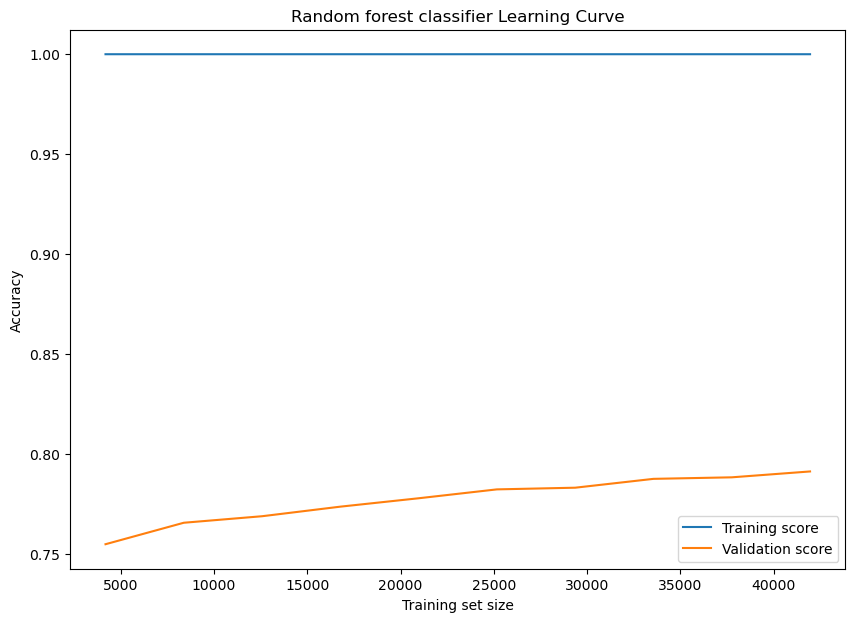

In [25]:
plt.figure(figsize=(10,7))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Random forest classifier Learning Curve')
plt.legend()
plt.show()


In [ ]:
catboost = CatBoostClassifier(iterations=200, loss_function='CrossEntropy', eval_metric='Accuracy', 
                              random_seed=42,data_partition='FeatureParallel',early_stopping_rounds=20)
grid = {'learning_rate': [0.03,0.01,0.1, 0.2,0.4],
        'depth': [1,2,4,6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = catboost.randomized_search(grid,
                                                   X=train_dataset_image_Scaled,
                                                   y=train_dataset_label,
                                                   plot=True)

# # task_type="GPU"

In [ ]:
randomized_search_result 

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

#Grayscale fit
'params': {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.2},

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

In [ ]:
#Kør denne model

catboost = CatBoostClassifier(iterations=2000, learning_rate=0.2, depth=6,l2_leaf_reg=7, loss_function='CrossEntropy', eval_metric='Accuracy', random_seed=42,data_partition='FeatureParallel' )
fitted_catboost = catboost.fit(train_dataset_image_Scaled, train_dataset_label,eval_set=(validation_dataset_image_Scaled, validation_dataset_label), use_best_model=True, plot = True)



In [56]:
#show me what is inside fitted_catboost
y_test_hat = fitted_catboost.predict(test_dataset_image_Scaled)
accuracy = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

Baseline model accuracy: 74.9% accuracy.


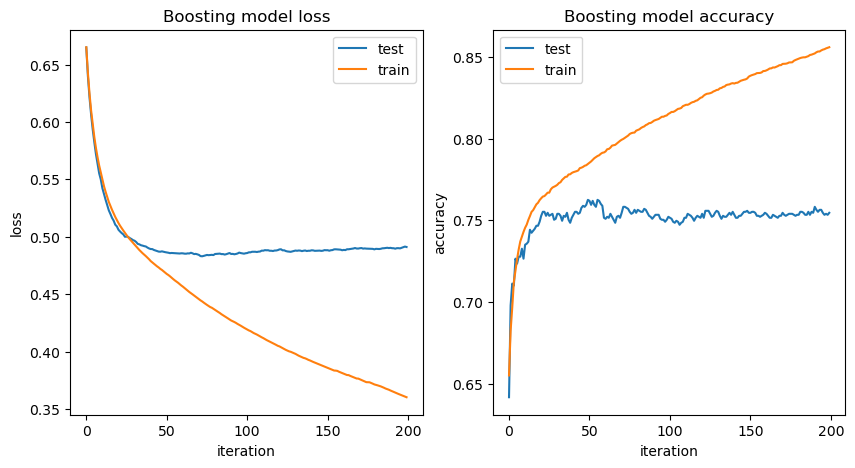

In [54]:


#from tsv file to dataframe

df_test = pd.read_csv(file_dir + r'\catboost_info\test_error.tsv', sep='\t')
df_train = pd.read_csv(file_dir + r'\catboost_info\learn_error.tsv', sep='\t')
#plot accuracy and loss from dataframe 


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(df_test['CrossEntropy'][0:200])
plt.plot(df_train['CrossEntropy'][0:200])
plt.title('Boosting model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['test', 'train'], loc='upper right')


plt.subplot(1,2,2)
plt.plot(df_test['Accuracy'][0:200])
plt.plot(df_train['Accuracy'][0:200])
plt.title('Boosting model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['test', 'train'], loc='upper left')
plt.show()
